(sec:introcution_to_bayesian_inference)=

# Introduction to Bayesian Inference

In this section, I want to illustrate some basic ideas of "classification." It will help us to understand some of the notation and some of the general concepts used throughout this document. It will illustrate the role of priors, the problem of classification in the context of imbalanced classes, and how to estimate classification performance correctly. Finally, it will also describe and provide some of the most important tools we will use for the data and statistical analysis. 

(example:screening_for_asd_headturn)= 

## Example: Screening for Autism Spectrum Disorder
Let us start with an example. Assume we have the task of determining whether a child has Autism Spectrum Disorder (ASD), and we have available, only one clinical measure "x." 

```{admonition} Notation
The universe of subjects/samples will be noted as $\mathcal{U}$, for each subject $s_i\in\mathcal{U}$, its ground truth label is represented by $y_i$, in this example we associate the value $y=1$ with the ASD group (and $0$ otherwise). The feature $X$ is a measure we will use for classification/prediction, $x_i$ represent the value of the feature for the subject $s_i$. 
```

An example of feature is the delay on head-turning after a name call.{cite}`campbell2019computer` For example, given a subject $s_i$, we are provided with a value $x_i$ that corresponds to the subjects' delay in seconds after his/her name is called. Given this information, we want to infer what is the probability that the child has ASD or not ($y_i=1$ or $y_i=0$). Let's build a numerical example.

```{Caution}
All the number and experiments here presented are made up. This document focuses on the mathematical tools, and is not intended to present or analyze any real data nor extract real behavioral conclusion. 
```

In [30]:
# import pre-installed packages and init. 
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys 
from myst_nb import glue

# add tools path and import our own tools
sys.path.insert(0, '../tools')
%load_ext autoreload
%autoreload 2
mpl.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Let us create some toy data:
from create_data import create_headturn_toy_example
X_u, Y_u = create_headturn_toy_example(num_points=1e5, prop_positive=0.05)
X, Y = create_headturn_toy_example(num_points=1e3, prop_positive=0.2)

`X_u` and `Y_u` denote the set of $x$ and $y$ values for the subjects in our universe $\mathcal{U}$. We simulated that there are $10k$ kids in our target population $\mathcal{U}$. On the other hand, `X` and `Y` represent a dataset we have available, i.e., the kids that came to the clinic. The main objective is to use our sample $(X,Y)$ to develop and evaluate tools that work on our target population with data $(X_u,Y_u)$.   

**The priors might vary between the target population and the set available.** In this experiment, we model that 5% of the kids in $\mathcal{U}$ have ASD. In our sample $(X,Y)$ on the other hand, we simulated a larger proportion of ASD children: 20%. This means that for the data we have available, we have four times more chances of sampling an ASD child if we select a child at random. Overrepresenting the minority class when empirical data is collected is a common and reasonable practice. We want to learn key features that represent both classes, and we need a considerable number of samples from both categories. Sampling at random from $\mathcal{U}$ would be very inefficient in terms of getting samples from the minority class (since we are considering imbalanced problems). Instead, we can work with a set that over-represents the minority class and correct the metrics, so the performance matches the prior in the actual population, as we discuss in the following. ADDREF

### Identifying and assessing descriptive features. 
Let's start to look into the data and try to get some idea about the following questions: **Q1: Is the head turn delay a useful feature for the diagnosis of ASD? If the answer is "Yes," Q2: how reliable this biomarker is?**

To answer the previous questions, we can start by looking at the data we have available $(X,Y)$:

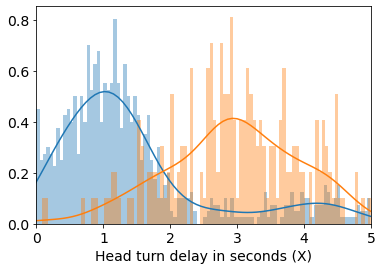

In [32]:
# Compute and plot the histogram of X values for each clas. 
df = pd.DataFrame({'X':X,'Y':Y}); 
fig = plt.figure()
sns.distplot(df.query('Y==0')['X'],bins=100, kde=True); 
sns.distplot(df.query('Y==1')['X'],bins=100, kde=True); 
plt.xlabel('Head turn delay in seconds (X)'); plt.xlim([0,5]);

glue("hist_head_turn_lab", fig, display=False)

```{glue:figure} hist_head_turn_lab
:figwidth: 50%
:name: "fig:hist_head_turn_lab"

Distribution of the head turn values on the sample data (X,Y). The blue and orange distributions represent the histogram across the non-ASD and ASD groups respectively, (P(X|Y)).
```

Looking at the results of {numref}`fig:hist_head_turn_lab`, the answer to Q1 seems to be YES! Head-turn delay looks like a descriptive biomarker for autism (recall this is just simulated data and a toy example). For the moment, we are answering the question informally, just by looking at the blue and orange distributions and observing that _they look different_. Of course a more formal statistical approach can be adopted, which is the subject of Section {ref}`sec:hypothesis_testing`.  

; kids in the non-ASD group seem to be turning their heads faster after a name call. Moreover, it looks that if the delay is below one second, we are almost certain the kid belongs to the non-ASD group. At the same time, for values larger of 2s, the result suggest that there is a higher chance for the kid to be on the ASD group. So, how accurate is this feature? The answer is, "it depends," we will address this formally in the following.  

_Footnote: ** This is an illustrative synthetic example, not actual data, don't take these conclusions literally._

The plots in Figure 1.1 might be miss-leading. If we look at the distribution of values of delays, it seems that for a delay of 2-3 seconds, the likelihood of the kid to be ASD is much higher than non-ASD. And we might then jump into the (wrong) conclusion: if $x_i\in[2,3]$ then $P(y_i=1)>>P(y_i=0)$ most likely he/she is ASD. This is incorrect. The previous plot is not showing the actual probability, but rather, conditional probabilities (this is going to be more clear later). 

Let see how the actual distribution of head turn delay looks in our universe of subjects:

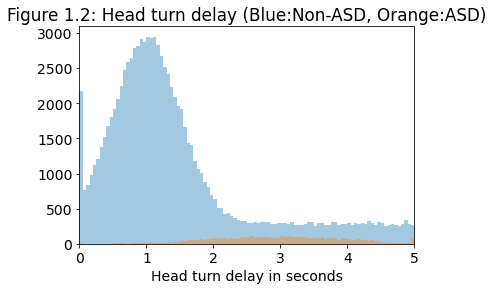

In [33]:
df = pd.DataFrame({'X':X_u,'Y':Y_u}); 
sns.distplot(df.query('Y==0')['X'],bins=100, kde=False); 
sns.distplot(df.query('Y==1')['X'],bins=100, kde=False); 
plt.xlim([0,5]); plt.title('Figure 1.2: Head turn delay (Blue:Non-ASD, Orange:ASD)'); 
plt.xlabel('Head turn delay in seconds');

When we look at the actual histograms, we see that, even for delays in the interval \[2-3\] seconds, the probability of the kid of being non-ASD is significantly larger than being ASD. This happens because the vast majority of the kids are on the non-ASD group (in this example, we set the proportion of ASD samples as 5% of the population). Working with this kind of problem is challenging, and they are usually framed as "imbalanced problems." Imbalanced means that one of the classes is much more frequent than the other. Classes imbalance poses challenges in particular, on how we measure performance (we will discuss performance measures in detail in the following). For example, let say we always label kids as non-ASD (without even looking at the value of $x$). We would be right 95\% of the time! But, of course, that solution is useless. 

At this point, two important conclusions should be taken. (1) The proportion of ASD/non-ASD kids matters when we want to make conclusions. And a warning: the ratio in our "lab" dataset might not represent the actual proportion in the universe. (2) Performance metrics need to be carefully selected (we will address this in Section X).    

(1) Can be formalized using bayes ideas [1, 7]. Bayes theorem (one of the pillars of machine learning) states:
$$
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}.
$$

In our illustrative example, this theorem reads as: "the probability of a subject being in the ASD group, given that I observed a delay value of 2s, is proportional to the probability of kids on the ASD group to present a delay of 2s, times the probability of finding an ASD if I pick a kid at random from the entire population." This equation is useful because it shows the role of priors explicitly. $P(X|Y)$ is what we are showing in Figure 1.1 (for $Y=1$ in orange and $Y=0$ in blue), and the probability $P(X|Y)P(Y)$ is illustrated in Figure 1.2. 

In general, we only care about the value of $P(Y=1|X)$ relative to the value of $P(Y=0|X)$, this is, we don't really care about the actual probability but rather, given a measure of "x" is $P(y=1|x)>>P(y=0|x)$, $P(y=1|x)\approx P(y=0|x)$, or $P(Y=1|X)<<P(Y=0|X)$. In the first case we might conclude "most likely this kid is ASD", in the second "I don't really know", and in the third, "This kids most likely isn't ASD." 

A formal way of measuring the relative probability, is to compute 
$$
\frac{P(Y=1|X)}{P(Y=0|X)} = \frac{P(X|Y=1)P(Y=1)}{P(X|Y=0)P(Y=0)}.
$$
For example, if $\frac{P(Y=1|X)}{P(Y=0|X)}=2$, it means that given this value of "X" the probability of the subject to be in the ASD group is twice the probability of being in the non-ASD group. Notice that, in the case "X" has no information about "Y" (i.e., we are measuring a feature that is useless, e.g., the number of letters in the kid name)
$$
\frac{P(Y=1|X)}{P(Y=0|X)} \rightarrow \frac{P(Y=1)}{P(Y=0)}.
$$
This is, the probability of a kid to be in the ASD group is simply the proportion of ASD kids in the population. In this example, we set $P(Y=1)=5\%$ and $P(Y=0)=95\%$, and therefore $P(Y=1)/P(Y=0)=0.052$, this means, the probability of "discovering an ASD kid" at random is very low. Using this information as a baseline, one might want to ask, if we measure a feature "X," how much better this is than guessing at random. We can formalize this idea as 
$$
\frac{\frac{P(Y=1|X)}{P(Y=0|X)}}{\frac{P(Y=1)}{P(Y=0)}} = \frac{P(X|Y=1)}{P(X|Y=0)}.
$$
This equation is interesting because the right side is "how much better this feature gets us compared to a random guess." Meanwhile, the right term is available: is what we measure in the clinic! (e.g., is illustrated in Figure 1.1). Also, we don't have to worry about the priors, nor the fact that the proportion of ASD kids in our lab isn't the same as in the entire population.

Figure 1.3 shows the quantity $\frac{P(X|Y=1)}{P(X|Y=0)}$ for our toy example "head-turn delay".

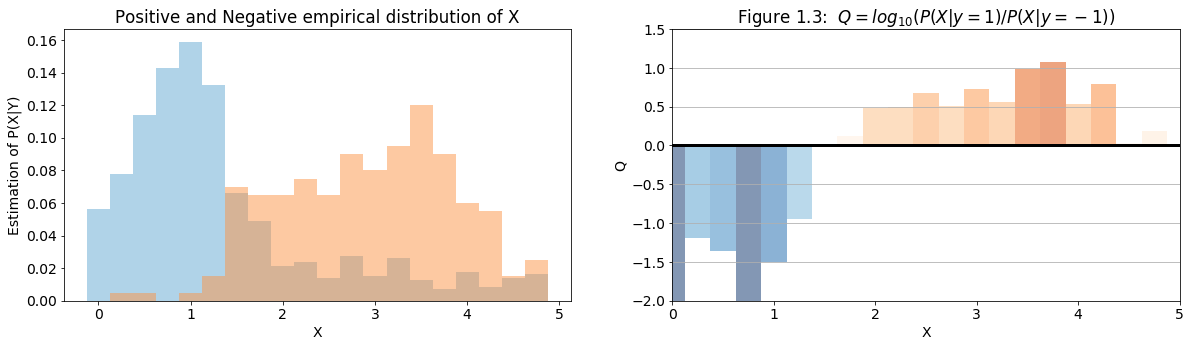

In [167]:
from stats import feature_values_positive_to_negative_ratio
Xp = X[Y==1]; Xn = X[Y==0]
Q = feature_values_positive_to_negative_ratio(Xp=Xp, Xn=Xn, verbose=1, num_bins=20)
plt.gca().set_title('Figure 1.3:  ' + plt.gca().get_title());

This type of analysis has more information than a "p-value" like approach (we will discuss those approaches latter). For example, a hypothesis test can answer the questions: Are the distributions $P(X|Y=1)$ and $P(X|Y=-1)$ the same? Do the distributions $P(X|Y=1)$ and $P(X|Y=-1)$ have the same mean? As we will see in the following section, a hypothesis test will answer for this example: these distributions are not the same, and they have a different mean. This translated to "the feature you are measuring makes sense, and is in principle, useful for the screening of ASD." However, it doesn't give any information regarding the accuracy of the tool once a value of the feature is observed. 

For example, observing a delay of 0.5 seconds, we can be almost certain that this kid belongs to the non-ASD group. In contrast, if we observe a delay of 1.5 seconds, we are not that sure about what to conclude. This information is formally provided in the expression presented above. Figure 1.3 provides the ratio  
$$
\frac{\frac{P(Y=1|X)}{P(Y=0|X)}}{\frac{P(Y=1)}{P(Y=0)}} = \frac{P(X|Y=1)}{P(X|Y=0)}.
$$
in logarithmic scale (we truncated the values to -2 and +1.5), let us call this quantity $Q$ for compactness. For example, $Q(3)=0.7$ means that if we select the group of kids for which the head turn delay is 3 seconds, and we take random samples, we are $10^{0.7}\approx 5$ times more likely to sample kids from the ASD group compared to sampling at random on the population. In contrast, values of $Q(x)$ close to $0$ indicate that the observed value does not provide any actual information. If we sample out of the kids in that group, we will obtain a similar performance as if we randomly sample from the population. Notice that both positive and negative values (far from 0) give valuable information. Positive values indicate that we have a _concentration_ of ASD (in other words, it indicates evidence of ASD), while negative values a _concentration_ of non-ASD (evidence for non-ASD).   

#### Useful performance measures for imbalance problems
Let assume after analysis, we decide we will predict ASD versus non-ASD labels depending on the kid's head turn delay after a name call. For example, we can define $\hat{y} \stackrel{def}{=} x>2$, this is, $\hat{y}=1$ for all the kids which response is slower than two seconds, and $\hat{y} = 0$ for all the kids which response is faster or equal than two seconds. Recall that for each participant we have their ground truth label $y=1$ if they are in the ASD group, $y=0$ if they are in the non-ASD group. 

Four quantities fully describe the performance of a classification algorithm: number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN). The TP is define as the number of subject for which $y=1$ and $\hat{y}=1$, TN the number of subject for which $y=0$ and $\hat{y}=0$, FP the number of subject for which $y=0$ and $\hat{y}=1$ and finally, FN the number of subjects for which $y=1$ and $\hat{y}=0$. 

Some useful metrics for the evaluation of classifiers are: Accuracy $\frac{TP+TN}{TP+TN+FP+FN}$, others? As we discussed earlier, measures such as the accuracy are not suited for imbalance problems. Instead, appropriate metrics are: recall $\frac{TP}{TP+FN}$ (a.k.a sensitivity, true positive rate), precision $\frac{TP}{TP+FP}$ (a.k.a. positive predictive value), f-value (which is a weighted average between recall and precision), true negative rate $\frac{TN}{TN+FP}$, or false positive rate $\frac{FP}{FP+TN}$. Another family of metrics provides information about a "family" of solutions rather than the performance on particular operation points. For example, the ROC curve shows the false positive rate (horizontal axis) versus the true positive rate (vertical axis). It is important to notice that the ROC curve does not provide the performance of a particular implementation. (There is no particular fixed labels nor fixed values for the TP, TN, FP, and FN). Instead, it shows a "family" of solutions when one hyper-parameter (typically a classification threshold) varies. To overcome this limitation, measures such as the area under the roc curve (AUC) have been proposed.

_Warning_:  If the proportion of positive and negative samples in the dataset is different from the ratio in the entire population (which in general happens in the clinic), some of the measures listed above will be skewed. To have an accurate performance estimation, this issue should analyzed. (Maybe later we add a section on how to address this issue, for now at least take this warning into account). 

### Summary
We discussed the role of priors, and why measuring "detection" in problems with imbalance classes is not trivial. We discussed how Bayes's ideas provide a possible framework to formalize and explain these concepts. We showed that it is essential to add to the extracted features, confidence measures with a probabilist and interpretable meaning. 

So far, we assumed we could approximate $P(X|Y)$ by measuring the "histogram" of the observed values of $X$ over an empirical sample. Section 2 formalizes this concept and discusses how to calculate the estimation error and confidence intervals. The previous discussion is very informative but is somehow complicated. Sometimes we just want to know, is X a useful feature or not? This kind of "binary" question is answered with hypothesis testing, which we discuss in Section 3. 